# Classification using metadata


In [20]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, TargetEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Dataset


In [21]:
# handling different type of data in the dataset
to_drop_columns = ['isic_id', 'patient_id', 'image_type', 'attribution', 'copyright_license', 'lesion_id']
one_hot_columns = ['age_approx','sex', 'anatom_site_general', 'tbp_tile_type','tbp_lv_location', 'tbp_lv_location_simple']
numerical_columns = ['clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
                     'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext',
                     'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
                     'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity',
                     'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
                     'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
                     'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z']
train_only_columns = ['iddx_full', 'iddx_1', 'iddx_2','iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index',
                      'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence']


In [22]:
# loading the datasets
train_metadata_unprocessed = pd.read_csv('dataset/train-metadata.csv',low_memory=False)
test_metadata_unprocessed = pd.read_csv('dataset/test-metadata.csv',low_memory=False)
#PATH = '../isic-2024-challenge/'
#train_metadata_path = os.path.join(PATH, 'train-metadata.csv')
#train_metadata_unprocessed = pd.read_csv(train_metadata_path)

#test_metadata_path = os.path.join(PATH, 'test-metadata.csv')
#test_metadata_unprocessed = pd.read_csv(test_metadata_path)

train_metadata = train_metadata_unprocessed.copy()
test_metadata = test_metadata_unprocessed.copy()


### Downsampling
We noticed a class imbalance in the target, so we downsampled the dataset to have a similar number of instances for two classes.

In [23]:
# sampling the dataset to avoid overfitting
positives = train_metadata_unprocessed[train_metadata_unprocessed['target'] == 1]
negatives = train_metadata_unprocessed[train_metadata_unprocessed['target'] == 0]

n_samples = positives.shape[0]

sampled_negatives = negatives.sample(n=n_samples, random_state=42)

train_metadata = pd.concat([sampled_negatives, positives])

print(train_metadata['target'].value_counts())


target
0    393
1    393
Name: count, dtype: int64


### Non relevant features
We dropped some features that were not relevant for the training

In [24]:
# dropping non relevant columns
train_metadata = train_metadata.drop(columns=to_drop_columns,errors='ignore')
test_metadata = test_metadata.drop(columns=to_drop_columns,errors='ignore')

# dropping columns only in train metadata
train_metadata = train_metadata.drop(columns=train_only_columns,errors='ignore')

# aligning the dataset to ensure they have the same columns
train_metadata, test_metadata = train_metadata.align(test_metadata, join='outer', axis=1, fill_value=0)

print(train_metadata['target'].value_counts())


target
0    393
1    393
Name: count, dtype: int64


### Features encoding
We encoded the data to make it suitable for the training.
Different type of data are handled differently:
*   Low cardinality categorical features: one-hot encoding
*   Numerical data: standardization



In [25]:
# one-hot encoding for low cardinality features
train_one_hot = []
test_one_hot = []

for c in train_metadata.columns:
  if c in one_hot_columns:
    train_one_hot.append(c)
  if c in test_metadata.columns:
    test_one_hot.append(c)


train_metadata = pd.get_dummies(train_metadata, columns=train_one_hot)
test_metadata = pd.get_dummies(test_metadata, columns=test_one_hot)

train_metadata, test_metadata = train_metadata.align(test_metadata, join='outer', axis=1, fill_value=0)

# standardizing numerical features
scaler = StandardScaler()
for c in numerical_columns:
  if c in train_metadata.columns:
    train_metadata[c] = scaler.fit_transform(train_metadata[[c]])
  if c in test_metadata.columns:
    test_metadata[c] = scaler.transform(test_metadata[[c]])


### Features selection
To reduce the number of features, we performed an analysis to indentify the most important ones.

#### Correlation matrix
The correlation matrix shows the correlation of the features with the target.

In [26]:
# separating features and target
X_train = train_metadata.drop(columns=['target'], errors='ignore')
y_train = train_metadata['target']

# correlation matrix
correlation_matrix = train_metadata.corr()

target_correlation = correlation_matrix['target'].abs().sort_values(ascending=False)
print("correlation with target:\n",target_correlation)

print(train_metadata['target'].value_counts())

correlation with target:
 target                       1.000000
tbp_lv_H                     0.476984
tbp_lv_deltaB                0.424551
tbp_lv_Hext                  0.381171
tbp_lv_B                     0.350507
                               ...   
tbp_lv_y_1511.222                 NaN
tbp_lv_y_629.535888671875         NaN
tbp_lv_z_-15.019287109375         NaN
tbp_lv_z_-28.57605                NaN
tbp_lv_z_113.9801                 NaN
Name: target, Length: 184, dtype: float64
target
0    393
1    393
Name: count, dtype: int64


#### Random forest model
We trained a Random Forest model to identify the most important features. It computes a features importance score.

In [27]:
# random forest model for feature importance
rf_model = RandomForestClassifier(random_state=26)
rf_model.fit(X_train, y_train)

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

feature_importances = feature_importances.sort_values(ascending=False)

print("Feature Importances:")
print(feature_importances)

Feature Importances:
clin_size_long_diam_mm             0.072448
tbp_lv_H                           0.064675
tbp_lv_areaMM2                     0.063265
tbp_lv_perimeterMM                 0.053418
tbp_lv_minorAxisMM                 0.053378
                                     ...   
tbp_lv_areaMM2_2.12047288421843    0.000000
tbp_lv_areaMM2_3.39651             0.000000
tbp_lv_areaMM2_3.846876            0.000000
clin_size_long_diam_mm_3.16        0.000000
tbp_lv_Aext_9.65796440333733       0.000000
Length: 183, dtype: float64


#### Features selection

We selected the features that were either classified as important by the RF model or highly correlated with the target class


Correlation with target:

tbp_lv_H
tbp_lv_deltaB
tbp_lv_Hext
tbp_lv_B
tbp_lv_areaMM2
tbp_lv_perimeterMM
tbp_lv_minorAxisMM
clin_size_long_diam_mm
tbp_lv_Aext
tbp_lv_stdLExt
tbp_lv_radial_color_std_max
tbp_lv_nevi_confidence
tbp_lv_color_std_mean
tbp_lv_norm_color
tbp_lv_A
tbp_tile_type_3D: XP
tbp_tile_type_3D: white
anatom_site_general_head/neck
tbp_lv_location_simple_Head & Neck
tbp_lv_location_Head & Neck
tbp_lv_Bext
tbp_lv_area_perim_ratio
tbp_lv_y
tbp_lv_norm_border
tbp_lv_location_Right Leg - Upper
tbp_lv_deltaLBnorm
tbp_lv_deltaLB
tbp_lv_C
tbp_lv_stdL
tbp_lv_deltaL
tbp_lv_symm_2axis
age_approx_60.0
age_approx_50.0
tbp_lv_z
anatom_site_general_lower extremity
tbp_lv_location_simple_Right Leg
age_approx_35.0
tbp_lv_location_Unknown
tbp_lv_location_simple_Unknown
tbp_lv_x
age_approx_40.0
age_approx_70.0
tbp_lv_location_Torso Front Bottom Half
age_approx_65.0
tbp_lv_location_simple_Right Arm
age_approx_75.0
tbp_lv_location_Right Arm - Lower
tbp_lv_deltaA
tbp_lv_eccentricity
tbp_lv_lo

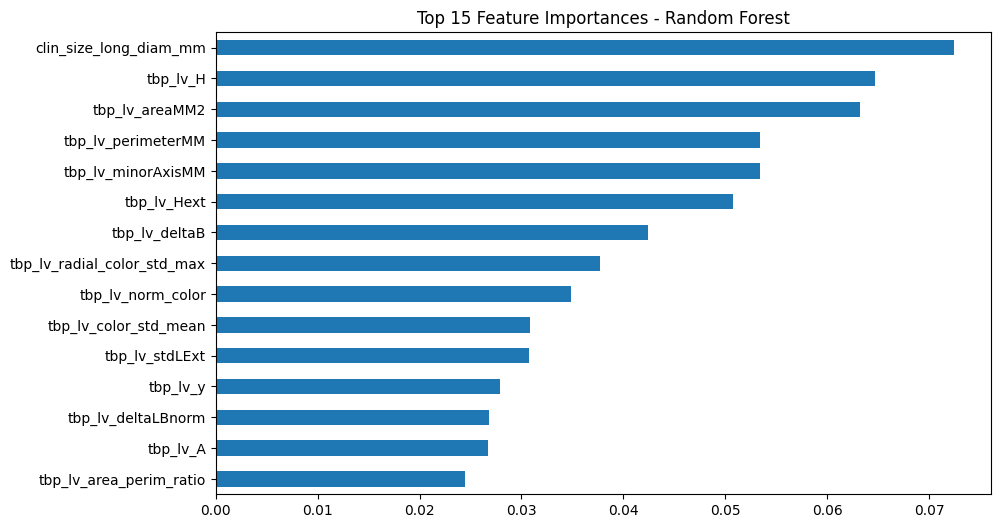

Top features
age_approx_35.0
age_approx_40.0
age_approx_50.0
age_approx_60.0
age_approx_65.0
age_approx_70.0
age_approx_75.0
anatom_site_general_head/neck
anatom_site_general_lower extremity
clin_size_long_diam_mm
tbp_lv_A
tbp_lv_Aext
tbp_lv_B
tbp_lv_Bext
tbp_lv_C
tbp_lv_H
tbp_lv_Hext
tbp_lv_areaMM2
tbp_lv_area_perim_ratio
tbp_lv_color_std_mean
tbp_lv_deltaA
tbp_lv_deltaB
tbp_lv_deltaL
tbp_lv_deltaLB
tbp_lv_deltaLBnorm
tbp_lv_eccentricity
tbp_lv_location_Head & Neck
tbp_lv_location_Left Arm - Lower
tbp_lv_location_Right Arm
tbp_lv_location_Right Arm - Lower
tbp_lv_location_Right Leg - Upper
tbp_lv_location_Torso Front Bottom Half
tbp_lv_location_Unknown
tbp_lv_location_simple_Head & Neck
tbp_lv_location_simple_Right Arm
tbp_lv_location_simple_Right Leg
tbp_lv_location_simple_Unknown
tbp_lv_minorAxisMM
tbp_lv_nevi_confidence
tbp_lv_norm_border
tbp_lv_norm_color
tbp_lv_perimeterMM
tbp_lv_radial_color_std_max
tbp_lv_stdL
tbp_lv_stdLExt
tbp_lv_symm_2axis
tbp_lv_x
tbp_lv_y
tbp_lv_z
tbp_tile

In [28]:
# keeping features that are highly correlated with the target or classified as important
correlated_features = target_correlation[abs(target_correlation) >= 0.05].index
correlated_features = correlated_features.drop('target')

print("Correlation with target:\n")
for cf in correlated_features:
  print(cf)

rf_features = feature_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
rf_features.plot(kind='barh')
plt.title('Top 15 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.show()

top_features = correlated_features.union(rf_features.index)

# converting to a list
top_features_list = list(top_features)

print("Top features")
for tf in top_features_list:
  print(tf)


In [29]:
# filtering the features
X_train = train_metadata[top_features]
y_train = train_metadata['target']

print(train_metadata['target'].value_counts())
print(X_train.shape)
print(y_train.shape)

target
0    393
1    393
Name: count, dtype: int64
(786, 51)
(786,)


### Splitting the dataset

In [30]:
# creating validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

# creating test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)
X_val = X_val.astype(float)
y_val = y_val.astype(float)

print(X_train.size)
print(X_val.size)
print(X_test.size)

32436
4029
3621


# Model
We used a Multi-Layer Perceptron (MLP), to capture non-linear relationships between the different features. It has three hidden layers (fully connected layers), each followed by batch normalization and using a ReLU activation function.

In [31]:
# Model - MLP
# converting to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [32]:
# defining dataset and data loader
class metadataDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = metadataDataset(X_train, y_train)
val_dataset = metadataDataset(X_val, y_val)
test_dataset = metadataDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [33]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# defining MPL model
class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super(MLPModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

input_dim = X_train.shape[1]
print(input_dim)
model = MLPModel(input_dim)

# defining loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy
optimizer = optim.SGD(model.parameters(), lr=0.001)


51


In [34]:
# model training
epochs = 50
train_accuracy = []
val_accuracy = []
train_loss_l = []
val_loss_l = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        predictions = (outputs > 0.5).float()
        train_correct += (predictions == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_accuracy.append(train_correct / train_total)

    val_loss = 0
    val_correct = 0
    val_total = 0


    model.eval()

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            predictions = (outputs > 0.5).float()  # Convert logits to binary predictions
            val_correct += (predictions == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_accuracy.append(val_correct / val_total)

    train_loss_l.append(train_loss/len(train_loader))
    val_loss_l.append(val_loss/len(val_loader))

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")
    print(f"Train Accuracy: {(train_correct / train_total):.4f}, Val Accuracy: {(val_correct / val_total):.4f}")
    print("\n")

Epoch 1/50
Train Loss: 0.7112, Val Loss: 0.6871
Train Accuracy: 0.4969, Val Accuracy: 0.5570


Epoch 2/50
Train Loss: 0.6829, Val Loss: 0.6592
Train Accuracy: 0.5330, Val Accuracy: 0.5949


Epoch 3/50
Train Loss: 0.6547, Val Loss: 0.6400
Train Accuracy: 0.5818, Val Accuracy: 0.6835


Epoch 4/50
Train Loss: 0.6307, Val Loss: 0.6139
Train Accuracy: 0.6321, Val Accuracy: 0.7215


Epoch 5/50
Train Loss: 0.6142, Val Loss: 0.6022
Train Accuracy: 0.6604, Val Accuracy: 0.7215


Epoch 6/50
Train Loss: 0.5943, Val Loss: 0.5858
Train Accuracy: 0.7107, Val Accuracy: 0.7595


Epoch 7/50
Train Loss: 0.5859, Val Loss: 0.5734
Train Accuracy: 0.7044, Val Accuracy: 0.7722


Epoch 8/50
Train Loss: 0.5746, Val Loss: 0.5628
Train Accuracy: 0.7280, Val Accuracy: 0.7848


Epoch 9/50
Train Loss: 0.5658, Val Loss: 0.5471
Train Accuracy: 0.7374, Val Accuracy: 0.7848


Epoch 10/50
Train Loss: 0.5591, Val Loss: 0.5377
Train Accuracy: 0.7374, Val Accuracy: 0.8101


Epoch 11/50
Train Loss: 0.5503, Val Loss: 0.5321


#Results
To analyse the results, we use the accuracy and loss across the epochs for the validation and training set. After, we compute performance metrics (accuracy, precision, recall, F1 score and confusion matrix) on the test set (unseen data for the model).

#### Accuracy and loss across epoch

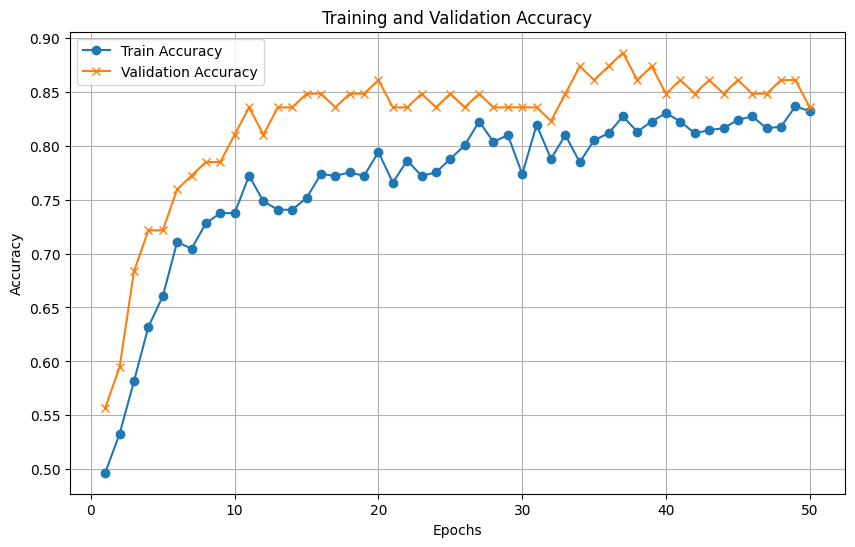

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracy, label="Train Accuracy", marker='o')
plt.plot(range(1, epochs + 1), val_accuracy, label="Validation Accuracy", marker='x')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

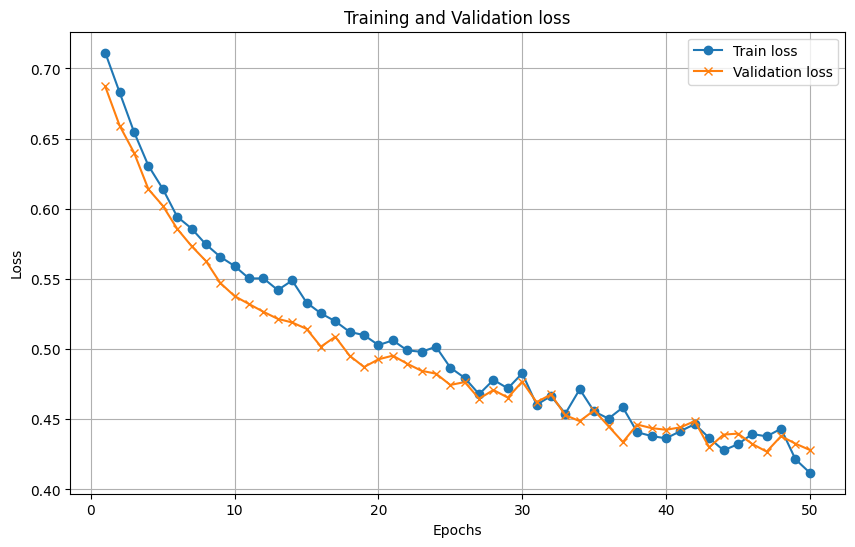

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_loss_l, label="Train loss", marker='o')
plt.plot(range(1, epochs + 1), val_loss_l, label="Validation loss", marker='x')
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

#### Performance on test set

In [37]:
# evaluation on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze()
    y_pred_binary = (y_pred > 0.5).float()

# training data predictions
train_preds = model(X_train).detach().numpy()
train_preds_binary = (train_preds > 0.5).astype(int)
train_accuracy = accuracy_score(y_train, train_preds_binary)

# evaluating data predictions
print(f"Training Accuracy: {train_accuracy:.4f}")

test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary, average='binary')
test_recall = recall_score(y_test, y_pred_binary, average='binary')
test_f1 = f1_score(y_test, y_pred_binary, average='binary')
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


print(classification_report(y_train, train_preds_binary))
print(classification_report(y_test, y_pred_binary))


Training Accuracy: 0.8616
Test Accuracy: 0.8592
Test Precision: 0.8824
Test Recall: 0.8333
Test F1 Score: 0.8571
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87       318
         1.0       0.89      0.82      0.86       318

    accuracy                           0.86       636
   macro avg       0.86      0.86      0.86       636
weighted avg       0.86      0.86      0.86       636

              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86        35
         1.0       0.88      0.83      0.86        36

    accuracy                           0.86        71
   macro avg       0.86      0.86      0.86        71
weighted avg       0.86      0.86      0.86        71



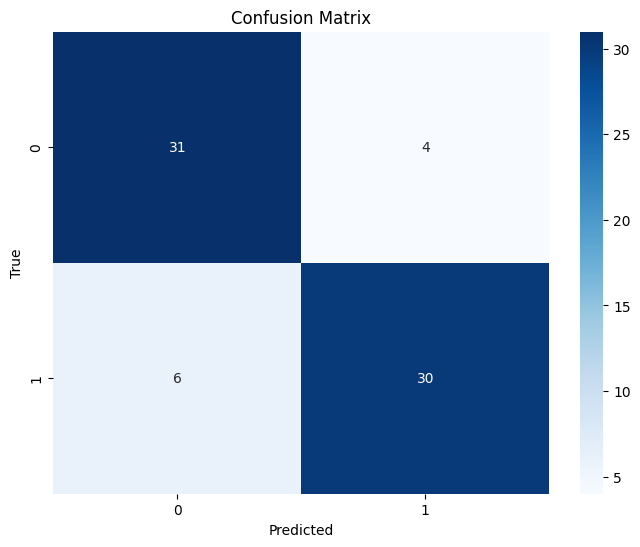

In [38]:
# Confusion Matrix
m = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8,6))
sns.heatmap(m, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()